In [7]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [8]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/bookcrossing-dataset/Books Data with Category Language and Summary/Preprocessed_data.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv


In [9]:
books = pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
ratings = pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
users = pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')

books.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [11]:
df.columns


Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [14]:

# Preprocessing
df = books.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop unnecessary columns if they exist
df.drop(columns=[
    'Unnamed: 0', 'location', 'isbn', 'img_s', 'img_m', 'city',
    'age', 'state', 'Language', 'country', 'year_of_publication'
], axis=1, errors='ignore', inplace=True)



df.head(2)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [53]:
# Read ratings
ratings = pd.read_csv(
    '/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv',
    sep=';',
    encoding='latin1',
    on_bad_lines='skip'
)

# Read book 
books = pd.read_csv(
    '/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv',
    sep=';',
    encoding='latin1',
    on_bad_lines='skip'
)

# Rename columns
# Rename for consistency
ratings.rename(columns={'User-ID': 'user_id', 'Book-Rating': 'rating'}, inplace=True)
books.rename(columns={'Book-Title': 'book_title', 'Image-URL-L': 'img_l'}, inplace=True)

# Merge on ISBN
df = pd.merge(ratings, books[['ISBN', 'book_title', 'img_l']], on='ISBN', how='left')

# Double-check
print(df.columns)


Index(['user_id', 'ISBN', 'rating', 'book_title', 'img_l'], dtype='object')


In [44]:
def item_based_recommender(book_title, books_df, df, threshold=180):
    import matplotlib.pyplot as plt
    from PIL import Image
    import requests

    book_title = str(book_title)

    required_cols = {'book_title', 'rating', 'user_id'}
    if not required_cols.issubset(df.columns):
        print("Missing required columns in the dataset.")
        return

    if book_title not in df['book_title'].values:
        print("Cannot find the book in the dataset, please check spelling.")
        return

    rating_counts = df['book_title'].value_counts()
    rare_books = rating_counts[rating_counts <= threshold].index
    common_books = df[~df['book_title'].isin(rare_books)]

    if book_title in rare_books:
        random_suggestions = pd.Series(common_books['book_title'].dropna().unique()).sample(2).values
        print("There are no recommendations for this book (too rare).")
        print(f"Try instead:\n{random_suggestions[0]}\n{random_suggestions[1]}")
        return

    user_book_df = common_books.pivot_table(index='user_id', columns='book_title', values='rating')
    target_book_vector = user_book_df[book_title]
    correlations = user_book_df.corrwith(target_book_vector).sort_values(ascending=False)
    recom_data = correlations.reset_index()
    recom_data.columns = ['book_title', 'corr']

    # Remove the input book from recommendations
    recom_data = recom_data[recom_data['book_title'] != book_title]

    # Remove books with average rating < 5
    avg_ratings = df.groupby('book_title')['rating'].mean()
    good_books = avg_ratings[avg_ratings >= 5].index
    recom_data = recom_data[recom_data['book_title'].isin(good_books)]

    top_recs = recom_data.head(5)

    # Plot recommendations
    fig, axs = plt.subplots(1, len(top_recs), figsize=(18, 5))
    fig.suptitle('You may also like these books', size=22)

    for i, title in enumerate(top_recs['book_title']):
        try:
            url = books_df.loc[books_df['book_title'] == title, 'img_l'].values[0]
            img = Image.open(requests.get(url, stream=True, timeout=5).raw)
            axs[i].imshow(img)
            axs[i].axis("off")
            rating = round(avg_ratings[title], 1)
            axs[i].set_title(f'Rating: {rating}', y=-0.18, color="red", fontsize=18)
        except:
            axs[i].axis("off")
            axs[i].set_title("Image Not Found", y=-0.18)

    plt.tight_layout()
    plt.show()


In [50]:
item_based_recommender("The Hobbit", books_df=books, df=df)


There are no recommendations for this book (too rare).
Try instead:
The Deep End of the Ocean
Prey: A Novel


In [ ]:
def safe_load_image(url):
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Could not load image from {url}: {e}")
        # Return a placeholder image
        return Image.open('placeholder.jpg')  

In [57]:
def content_based_recommender(book_title):
    book_title = str(book_title)

    if 'book_title' not in df.columns or 'rating' not in df.columns or 'user_id' not in df.columns:
        print("Required columns are missing. Please ensure 'book_title', 'rating', and 'user_id' exist.")
        return

    if book_title not in df['book_title'].values:
        print('Book not found. Please check the title.')
        return

    # Calculate book frequency
    rating_counts = pd.DataFrame(df['book_title'].value_counts()).reset_index()
    rating_counts.columns = ['book_title', 'count']

    rare_books = rating_counts[rating_counts['count'] <= 100]['book_title']
    common_books = df[~df['book_title'].isin(rare_books)]

    if book_title in rare_books.values:
        recommendations = pd.Series(common_books['book_title'].unique()).sample(2).values
        print('There are no recommendations for this book (too rare).')
        print('Try instead:\n{}\n{}'.format(recommendations[0], recommendations[1]))
        return

    user_book_df = common_books.pivot_table(index='user_id', columns='book_title', values='rating')
    book_vector = user_book_df[book_title]
    similarity = user_book_df.corrwith(book_vector)

    recom_data = pd.DataFrame(similarity).reset_index()
    recom_data.columns = ['book_title', 'corr']
    recom_data = recom_data[recom_data['book_title'] != book_title]

    # Filter out low average rating books
    avg_ratings = df.groupby('book_title')['rating'].mean().reset_index()
    avg_ratings.columns = ['book_title', 'avg_rating']

    recom_data = pd.merge(recom_data, avg_ratings, on='book_title')
    recom_data = recom_data[recom_data['avg_rating'] >= 5]

    top_recommendations = recom_data.sort_values('corr', ascending=False).head(5)

    # Plot
    fig, axs = plt.subplots(1, 5, figsize=(18, 5))
    fig.suptitle('You may also like these books', size=22)

    for i, title in enumerate(top_recommendations['book_title']):
        try:
            url = books.loc[books['book_title'] == title, 'img_l'].values[0]
            im = Image.open(requests.get(url, stream=True).raw)
            axs[i].imshow(im)
            axs[i].axis("off")
            avg_rating = round(df[df['book_title'] == title]['rating'].mean(), 1)
            axs[i].set_title(f'Rating: {avg_rating}', y=-0.18, color="red", fontsize=18)
        except:
            axs[i].axis("off")
            axs[i].set_title("Image Not Found", y=-0.18)

    plt.tight_layout()
    plt.show()


content_based_recommender('The Testament')

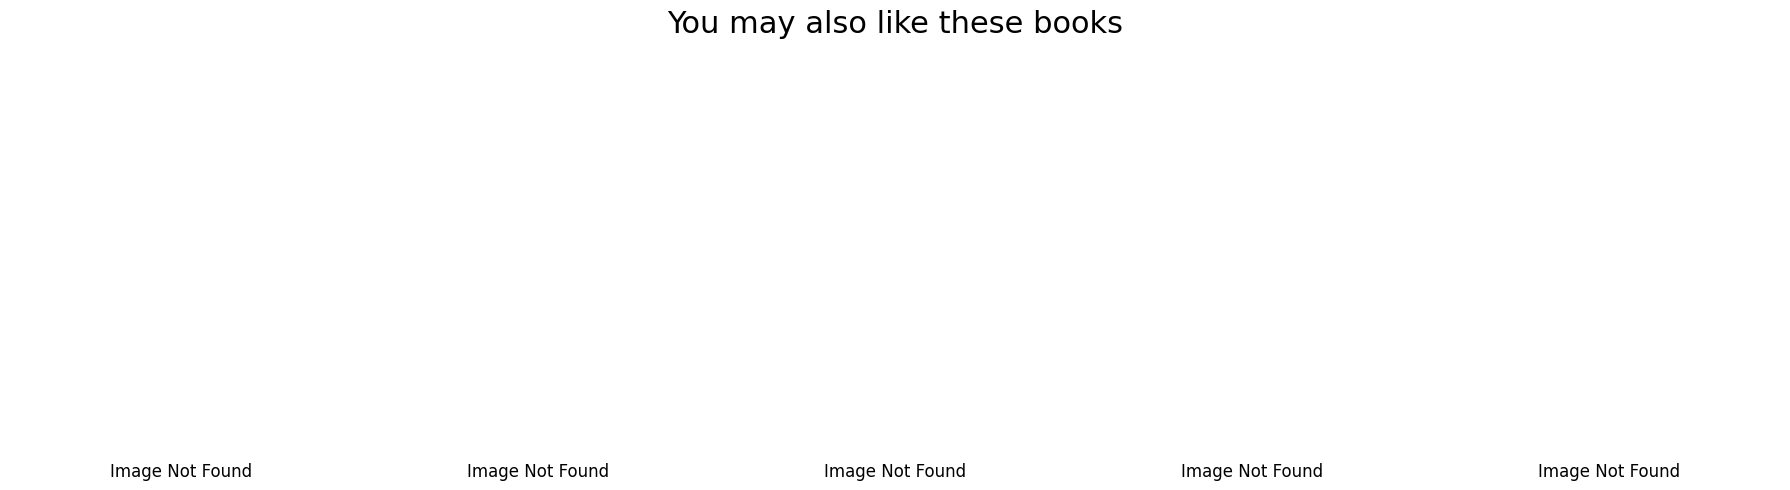

In [61]:
content_based_recommender('Animal Farm')